# Polar plots (azimuth, elevation)

**Links**

- https://pt.wikipedia.org/wiki/Sistema_horizontal_de_coordenadas
- https://matplotlib.org/examples/pylab_examples/polar_demo.html

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
"""
Demo of a line plot on a polar axis.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def degrees_to_radians(degrees):
    radians = (degrees * np.pi) / 180.0
    return radians
    
def azimuth_to_theta(az):
    '''input:  azimuth (degrees)
       output: angle in radians (radians)'''
    az = degrees_to_radians(az)
    theta = np.pi / 2.0 - az
    return theta

def elevation_to_radius(el):
    '''input:  azimuth (degrees) []
       output: angle in radians (radians)'''
    
    #el = abs(el)
    if el > 90.0:
        raise ValueError('Elevation must be in [-90.0, +90.0]')

    radius = 90.0 - el
    return radius

def is_point_visible(y):
    return y >= 0.0

def split_visible_points(x, y):
    visible = []
    invisible = []
    
    for i, yi in enumerate(y):
        point = (x[i], yi)
        if is_point_visible(yi):
            visible.append(point)
        else:
            invisible.append(point)
    return visible, invisible

def az_el_to_theta_radius(az_el):
    theta_radius = tuple((azimuth_to_theta(x), elevation_to_radius(y)) for x, y in az_el)
    return theta_radius

In [3]:
print(azimuth_to_theta(45.0))

0.7853981633974483


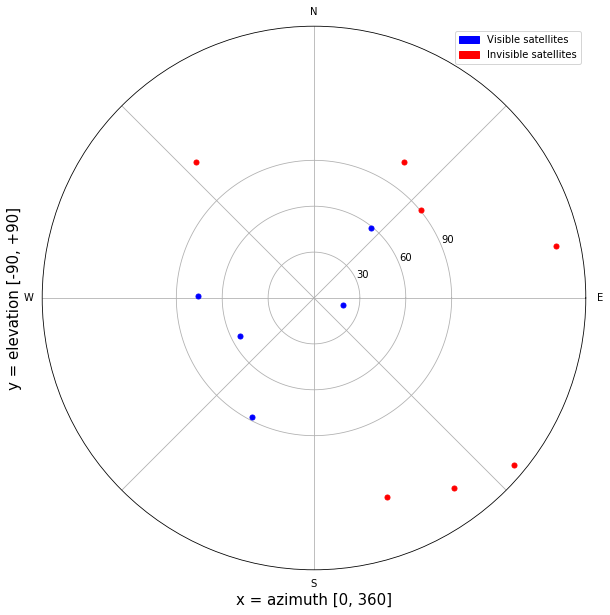

In [4]:
def plot_az_el(az, el):
    plt.figure(num=1, figsize=(10, 10)) 
    
    visible, invisible = split_visible_points(az, el)   
    points_color = {
        'b': az_el_to_theta_radius(visible),
        'r': az_el_to_theta_radius(invisible),
    }
    
    ax = plt.subplot(projection='polar')
    
    for color, points in points_color.items():
        if not points:
            continue 
            
        x, y = list(zip(*points))
        ax.plot(x, y, marker='o', linestyle='', ms=5, color=color)

    ax.set_rticks([30.0, 60.0, 90.0])
    ax.set_xticklabels(['E', '', 'N', '', 'W', '', 'S', ''])
    ax.set_xlabel('x = azimuth [0, 360]', fontsize=15)
    ax.set_ylabel('y = elevation [-90, +90]', fontsize=15, labelpad=20)
    
    visible_patch = mpatches.Patch(color='b', label='Visible satellites')
    invisible_patch = mpatches.Patch(color='r', label='Invisible satellites')
    
    plt.legend(handles=[visible_patch, invisible_patch])

    
def annotate_satellite(ax, az, el, dates):
    for i in range(len(az)):
        x = azimuth_to_theta(az[i])
        y = elevation_to_radius(el[i])
        xy = (x, y)
        
        label = '  {}'.format(i + 1)
        ax.annotate(label, xy, fontsize=12)
    
    points = list(zip(az, el, dates))
    df = pd.DataFrame(points, index=[i for i in range(1, len(points)+1)],
                     columns=['Azimuth', 'Elevation', 'Time'])
    display(df)
    
n = 12
az = np.random.uniform(size=n) * 360.0
el = np.random.uniform(low=-1.0, high=1.0, size=n) * 90.0

plot_az_el(az, el) 

### Rastreando N posições do satélite num espaço T de tempo

A biblioteca utilizada tem precisão a partir de 1 segundo. Ou seja, não há como estimar com precisão, utilizando a bibliteca, a posição do satélite em um determinado tempo que não é múltiplo de 1 segundo (por exemplo, 3.14 segundos).

In [5]:
OBS_LAT = -15.989620
OBS_LON = -48.044411
OBS_ALT = 500 # meters

ISS_TLE = ('1 25544U 98067A   18264.87214538 -.00000479 +00000-0 +00000-0 0 9990',
           '2 25544 051.6411 256.8919 0004651 185.2142 246.8508 15.53744581133552')

In [13]:
from datetime import datetime, timedelta, timezone

from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv
from sgp4.model import Satellite
import pymap3d as pm


def propagate_satellite(satellite, at):
    if not isinstance(satellite, Satellite):
        raise ValueError('sattelite parameter must be an instance of Satellite')
        
    if not (at.tzinfo == timezone.utc):
        raise ValueError('Time must be in UTC')
        
    date_at = at.year, at.month, at.day, at.hour, at.minute, at.second + (at.microsecond / 1000000.0)
    return satellite.propagate(*date_at)

def propagate_satellite_positions(satellite, start=None, count=20, step=1):
    '''Propagates the satellite positions in a equally-distant points in time'''
    if not isinstance(step, int):
        raise ValueError('step must be int')
    if step < 1:
        raise ValueError('step must be >= 1')
    
    if start is None:
        start = datetime.now(timezone.utc)
    
    dates = [start + timedelta(seconds=step * i) for i in range(count)]
    positions = np.array([(propagate_satellite(satellite, at)[0], at) for at in dates])
    return positions

In [7]:
satellite = twoline2rv(ISS_TLE[0], ISS_TLE[1], wgs84)
utc_satview = datetime(year=2018, month=9, day=22, hour=20, minute=37, second=30, tzinfo=timezone.utc)

iss_position, v = propagate_satellite(satellite, utc_satview)
iss_position = (iss_position[0] * 1000.0, iss_position[1] * 1000.0, iss_position[2] * 1000.0)

print('iss_position = {}'.format(iss_position))

iss_position = (768350.0713588104, 6538760.196343955, -1632694.711713458)


In [8]:
import pymap3d as pm


def see_satellite(satellite, obs_lat, obs_lon, obs_alt, start=None, count=10, step=30):
    positions_at = propagate_satellite_positions(satellite, start=start, count=count, step=step)
    azimuth = []
    elevation = []
    
    for position_at in positions_at:
        eci, date = position_at
        eci = [x * 1000.0 for x in eci]
        aer = pm.eci2aer(eci, obs_lat, obs_lon, obs_alt, date)
        az = aer[0][0]
        el = aer[1][0]
        
        azimuth.append(az)
        elevation.append(el)
        
    print(azimuth)
    print(elevation)
    
    plot_az_el(azimuth, elevation)
    dates = [x[1] for x in positions_at]
    ax = plt.gca()
    annotate_satellite(ax, azimuth, elevation, dates)
    plt.show()


In [9]:
OBS_LAT = -15.989620
OBS_LON = -48.044411
OBS_ALT = 500.0 # meters

[226.48560254710605, 229.06139839084963, 233.35689170269626, 241.71908942480727, 262.64644599547654, 317.024620642116, 359.29724616048543, 14.190476334413713, 20.770621820435327, 24.40286123323191, 26.705556336624444]
[1.8457413565487009, 6.347704617811734, 12.374944039986161, 21.465969071673126, 36.135315012830546, 45.30376258386547, 30.42373861032744, 17.7640222855288, 9.942835210388294, 4.536008162162599, 0.36322292292932024]


,Azimuth,Elevation,Time
1,226.485603,1.845741,2018-10-03 14:57:00+00:00
2,229.061398,6.347705,2018-10-03 14:58:00+00:00
3,233.356892,12.374944,2018-10-03 14:59:00+00:00
4,241.719089,21.465969,2018-10-03 15:00:00+00:00
5,262.646446,36.135315,2018-10-03 15:01:00+00:00
6,317.024621,45.303763,2018-10-03 15:02:00+00:00
7,359.297246,30.423739,2018-10-03 15:03:00+00:00
8,14.190476,17.764022,2018-10-03 15:04:00+00:00
9,20.770622,9.942835,2018-10-03 15:05:00+00:00
10,24.402861,4.536008,2018-10-03 15:06:00+00:00


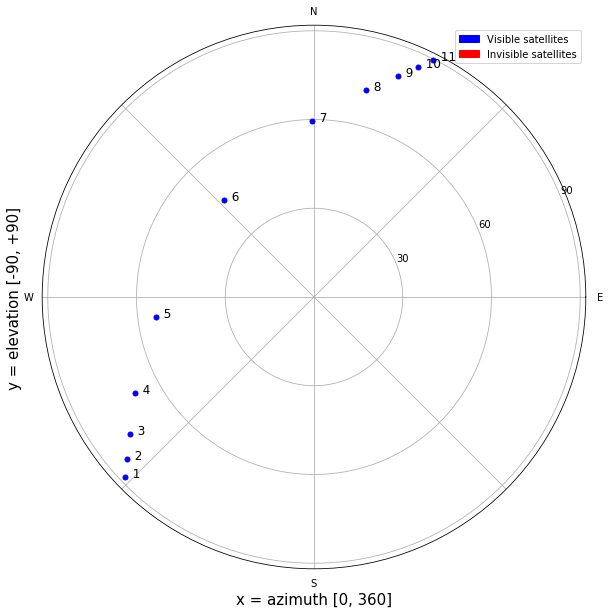

In [14]:
from datetime import timedelta


iss = satellite
start = datetime(year=2018,
                 month=10,
                 day=3,
                 hour=11,
                 minute=57,
                 second=0,
                 tzinfo=timezone.utc)

start += timedelta(hours=3)

see_satellite(iss, OBS_LAT, OBS_LON, OBS_ALT, start=start, count=11, step=60)